In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# extracted_features =  pd.read_csv("/content/drive/MyDrive/TFM_Javier_Eneritz/DATOS_TFM/features_savgol_81_8_total.csv")
extracted_features =  pd.read_csv("features_var_savgol_KEPID_total.csv")




In [ ]:
# y_fold = pd.read_csv("/content/drive/MyDrive/TFM_Javier_Eneritz/DATOS_TFM/labels_savgol_81_8_total.csv")
y_fold = pd.read_csv("labels_var_savgol_KEPID_total.csv")



In [ ]:
print(extracted_features)

      Unnamed: 0  EVEN__variance_larger_than_standard_deviation  \
0       10797460                                            0.0   
1       10797460                                            0.0   
2       10848459                                            0.0   
3       10854555                                            0.0   
4       10872983                                            0.0   
...          ...                                            ...   
6998    10199817                                            0.0   
6999    10031643                                            0.0   
7000    10090151                                            0.0   
7001    10147276                                            0.0   
7002    10156110                                            0.0   

      EVEN__has_duplicate_max  EVEN__has_duplicate_min  EVEN__has_duplicate  \
0                         0.0                      0.0                  1.0   
1                         0.0        

In [ ]:
print(y_fold)

      Unnamed: 0  label
0       10797460   True
1       10797460   True
2       10848459  False
3       10854555   True
4       10872983   True
...          ...    ...
6998    10199817  False
6999    10031643  False
7000    10090151  False
7001    10147276  False
7002    10156110  False

[7003 rows x 2 columns]


In [ ]:
y_fold = y_fold.iloc[:, 1:]

In [ ]:
print(y_fold)

      label
0      True
1      True
2     False
3      True
4      True
...     ...
6998  False
6999  False
7000  False
7001  False
7002  False

[7003 rows x 1 columns]


In [ ]:
y_fold.value_counts()

,count
label,
False,4364
True,2639


Eliminar acarcteristicas ruidosas

In [ ]:
type(y_fold)

pandas.core.frame.DataFrame

In [ ]:
y = y_fold.squeeze()  # Convierte a Series si solo hay una columna

In [ ]:
type(y)

pandas.core.series.Series

In [ ]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
impute(extracted_features)
features_filtered = select_features(extracted_features, y) ##Elimina características irrelevantes o ruidosas que no ayudan al modelo a predecir correctamente.


/usr/local/lib/python3.12/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['EVEN__query_similarity_count__query_None__threshold_0.0'
 'ODD__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [ ]:
print(y)

0        True
1        True
2       False
3        True
4        True
        ...  
6998    False
6999    False
7000    False
7001    False
7002    False
Name: label, Length: 7003, dtype: bool


In [ ]:
y.value_counts()

,count
label,
False,4364
True,2639


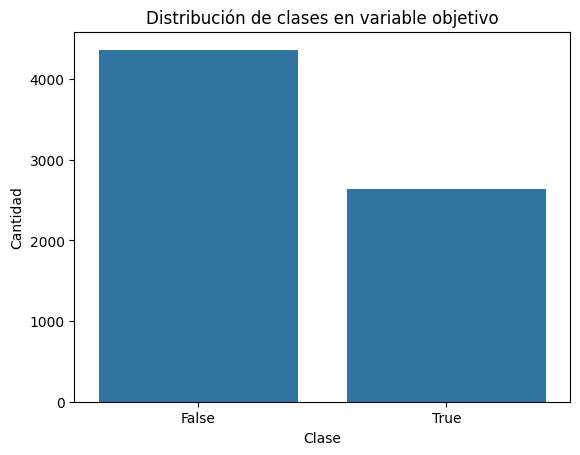

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y)
plt.title('Distribución de clases en variable objetivo')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()

Caracteristicas

In [ ]:
# asumiendo que features_filtered es tu DataFrame original
# 1) Extraemos los KEPID
kepi_ids = features_filtered["Unnamed: 0"].values

# 2) Creamos un nuevo DataFrame sin esa columna
X_df = features_filtered.drop(columns=["Unnamed: 0"])
print("Número de features:", X_df.shape[1])

# 3) Convertimos a numpy y escala
X = X_df.values.astype(np.float32)
y_np = y.values

Número de features: 612


Few-shot

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np

class FewShotDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.X)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Escalar
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Configuración Few-Shot
n_ways = 2        # clases por episodio
k_shots = 5       # ejemplos por clase para soporte
q_queries = 10    # ejemplos por clase para query

def create_episode(X, y, n_ways, k_shots, q_queries):
    available_classes = np.unique(y)
    classes = np.random.choice(available_classes, size=n_ways, replace=False)

    support_x, support_y, support_idx = [], [], []
    query_x, query_y, query_idx = [], [], []

    for cls in classes:
        idx_cls = np.where(y == cls)[0]   # índices originales de esa clase
        if len(idx_cls) < (k_shots + q_queries):
            continue
        perm = np.random.permutation(len(idx_cls))
        support_idx.extend(idx_cls[perm[:k_shots]])
        query_idx.extend(idx_cls[perm[k_shots:k_shots+q_queries]])
        support_x.append(X[idx_cls[perm[:k_shots]]])
        query_x.append(X[idx_cls[perm[k_shots:k_shots+q_queries]]])
        support_y.extend([cls]*k_shots)
        query_y.extend([cls]*q_queries)

    support_x = torch.tensor(np.concatenate(support_x), dtype=torch.float32)
    query_x = torch.tensor(np.concatenate(query_x), dtype=torch.float32)
    support_y = torch.tensor(support_y)
    query_y = torch.tensor(query_y)
    support_idx = torch.tensor(support_idx)
    query_idx = torch.tensor(query_idx)

    return support_x, support_y, support_idx, query_x, query_y, query_idx


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingMLP(nn.Module):
    def __init__(self, input_dim=features_filtered.shape[1], embed_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embed_dim)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
def prototypical_eval(model, support_x, support_y, query_x, query_y, query_idx):
    model.eval()
    with torch.no_grad():
        support_embed = model(support_x)
        query_embed = model(query_x)

        # centroides
        prototypes = []
        for cls in torch.unique(support_y):
            cls_embed = support_embed[support_y == cls]
            prototypes.append(cls_embed.mean(dim=0))
        prototypes = torch.stack(prototypes)

        dists = torch.cdist(query_embed, prototypes) ** 2
        log_p_y = F.log_softmax(-dists, dim=1)

        # etiquetas mapeadas
        query_labels = torch.tensor(
            [torch.unique(support_y).tolist().index(lbl.item()) for lbl in query_y],
            device=log_p_y.device
        )

        preds = log_p_y.argmax(dim=1)
        acc = (preds == query_labels).float().mean().item()

        # máscaras de correctos/incorrectos
        correct_mask = preds == query_labels
        incorrect_mask = ~correct_mask

        correct_ids = query_idx[correct_mask.cpu()].cpu().numpy()
        incorrect_ids = query_idx[incorrect_mask.cpu()].cpu().numpy()

    return acc, correct_ids, incorrect_ids


In [ ]:
def prototypical_loss(model, support_x, support_y, query_x, query_y):
    model.eval()
    support_embed = model(support_x)
    query_embed = model(query_x)

    # Calculamos centroides (prototipos) de cada clase
    prototypes = []
    for cls in torch.unique(support_y):
        cls_embed = support_embed[support_y == cls]
        prototypes.append(cls_embed.mean(dim=0))
    prototypes = torch.stack(prototypes)

    # Distancia euclídea al cuadrado
    dists = torch.cdist(query_embed, prototypes) ** 2
    log_p_y = F.log_softmax(-dists, dim=1)

    # Mapeo a clases (ordenadas como en torch.unique)
    query_labels = torch.tensor([torch.unique(support_y).tolist().index(lbl.item()) for lbl in query_y])
    loss = F.nll_loss(log_p_y, query_labels)
    acc = (log_p_y.argmax(dim=1) == query_labels).float().mean()
    return loss.item(), acc.item()


In [ ]:
from sklearn.model_selection import train_test_split

# ids globales
ids = np.arange(len(y_np))

# Split único y común
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y_np, ids, test_size=0.2, random_state=42, stratify=y_np
)


In [ ]:
def eval_fewshot_on_test(model, X_train, y_train, X_test, y_test, ids_test, n_ways=2, k_shots=5):
    """
    Evalúa few-shot en un conjunto de test fijo.
    Retorna accuracy + listas de IDs correctos/incorrectos.
    """
    model.eval()
    with torch.no_grad():
        available_classes = np.unique(y_test)

        # Seleccionamos algunas clases de test (ejemplo: n_ways)
        chosen_classes = np.random.choice(available_classes, n_ways, replace=False)

        support_x, support_y = [], []
        for cls in chosen_classes:
            idx_cls = np.where(y_train == cls)[0]
            if len(idx_cls) < k_shots:
                continue
            perm = np.random.permutation(len(idx_cls))
            support_x.append(X_train[idx_cls[perm[:k_shots]]])
            support_y.extend([cls]*k_shots)

        support_x = torch.tensor(np.concatenate(support_x), dtype=torch.float32)
        support_y = torch.tensor(support_y)

        query_x = torch.tensor(X_test, dtype=torch.float32)
        query_y = torch.tensor(y_test)
        query_idx = ids_test

        # embeddings
        support_embed = model(support_x)
        query_embed = model(query_x)

        prototypes = []
        for cls in torch.unique(support_y):
            cls_embed = support_embed[support_y == cls]
            prototypes.append(cls_embed.mean(dim=0))
        prototypes = torch.stack(prototypes)

        dists = torch.cdist(query_embed, prototypes) ** 2
        log_p_y = F.log_softmax(-dists, dim=1)

        # mapeamos etiquetas reales de query al espacio de prototipos
        mapping = {cls.item(): i for i, cls in enumerate(torch.unique(support_y))}
        valid_mask = np.array([lbl.item() in mapping for lbl in query_y])

        query_labels = torch.tensor([mapping[lbl.item()] for lbl in query_y[valid_mask]])
        preds = log_p_y[valid_mask].argmax(dim=1)

        acc = (preds == query_labels).float().mean().item()

        correct_mask = (preds == query_labels).cpu().numpy()
        incorrect_mask = ~correct_mask

        correct_ids = query_idx[valid_mask][correct_mask]
        incorrect_ids = query_idx[valid_mask][incorrect_mask]

    return acc, correct_ids, incorrect_ids


In [ ]:
model = EmbeddingMLP(input_dim=X_df.shape[1]).to("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for episode in range(300):
    support_x, support_y, support_idx, query_x, query_y, query_idx = create_episode(X, y_np, n_ways, k_shots, q_queries)
    support_x, support_y = support_x.to(model.net[0].weight.device), support_y.to(model.net[0].weight.device)
    query_x, query_y = query_x.to(model.net[0].weight.device), query_y.to(model.net[0].weight.device)

    model.train()
    optimizer.zero_grad()
    support_embed = model(support_x)
    query_embed = model(query_x)

    prototypes = []
    for cls in torch.unique(support_y):
        cls_embed = support_embed[support_y == cls]
        prototypes.append(cls_embed.mean(dim=0))
    prototypes = torch.stack(prototypes)

    dists = torch.cdist(query_embed, prototypes) ** 2
    log_p_y = F.log_softmax(-dists, dim=1)
    query_labels = torch.tensor([torch.unique(support_y).tolist().index(lbl.item()) for lbl in query_y]).to(log_p_y.device)

    loss = F.nll_loss(log_p_y, query_labels)
    acc = (log_p_y.argmax(dim=1) == query_labels).float().mean()

    loss.backward()
    optimizer.step()

    if episode % 20 == 0:
        print(f"Ep {episode}: Loss = {loss.item():.4f}, Acc = {acc.item():.4f}")

/tmp/ipython-input-565147615.py:35: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  support_y = torch.tensor(support_y)
/tmp/ipython-input-565147615.py:36: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  query_y = torch.tensor(query_y)


Ep 0: Loss = 0.7024, Acc = 0.5000
Ep 20: Loss = 0.5602, Acc = 0.8000
Ep 40: Loss = 0.5788, Acc = 0.6500
Ep 60: Loss = 0.7419, Acc = 0.5500
Ep 80: Loss = 0.7461, Acc = 0.4500
Ep 100: Loss = 0.6035, Acc = 0.5500
Ep 120: Loss = 0.6941, Acc = 0.5000
Ep 140: Loss = 0.6449, Acc = 0.6000
Ep 160: Loss = 0.7257, Acc = 0.5000
Ep 180: Loss = 0.5823, Acc = 0.7000
Ep 200: Loss = 0.3544, Acc = 0.8000
Ep 220: Loss = 0.8122, Acc = 0.6000
Ep 240: Loss = 0.6821, Acc = 0.5500
Ep 260: Loss = 0.6898, Acc = 0.5500
Ep 280: Loss = 0.5887, Acc = 0.6000


Evaluacion few-shot

In [ ]:
# Creamos un episodio de evaluación con el modelo entrenado
support_x, support_y, support_idx, query_x, query_y, query_idx = create_episode(X, y_np, n_ways, k_shots, q_queries)

# Pasamos a la misma device que el modelo
device = next(model.parameters()).device
support_x, support_y = support_x.to(device), support_y.to(device)
query_x, query_y, query_idx = query_x.to(device), query_y.to(device), query_idx.to(device)

# Evaluamos
acc_few, correct_ids_few, incorrect_ids_few = eval_fewshot_on_test(
    model, X_train, y_train, X_test, y_test, ids_test,
    n_ways=2, k_shots=5
)


print(f"\nEvaluación final -> Acc = {acc:.4f}")
print("Correctos (IDs originales):", correct_ids_few)
print("Incorrectos (IDs originales):", incorrect_ids_few)



Evaluación final -> Acc = 0.4133
Correctos (IDs originales): [  71 4919 3194 1801 4550  594 3479 6012 1513 3322 3079 3015 5039 1872
 6705 3340 6093 5958 5704 2532 4273 5496 5779 6593 6625  899 1828 5785
 5392 2853 2089 5562  102 5703 5588 6359 2031 2306 5168 2694 3756 3783
 2260 6802 6372 1431 3120 6918  330  338 6286 3431 2629 1774 1723 5133
 5435 6867 4304 4799 2378 1036 3612 5169 5405 3458 2726 3581 4313 3350
 4656  552  404 5535 6072 4330 3162 5464 6009 5373 1056 1720 2391 4346
   18 6756  240 2470 2355 6620  157 3289 3198 3572 4663 3468 2422  357
 6192 4995 5627 4404 5612 1227 5897 6033 3959 1130 6532 1067 6165 6034
 6332 4373 6863 1663  283 1186 5354 5616 2507 1185 6561 6835 6408 6871
 6055 5443 1263 4127 2564 6467 3960 3858 2727 4138  341 5819 4546 6560
 3694 4533 6480  346 6460 1200 6213 4619 6859 2396 6272 4087 4043 4639
 3811 6888 3666 6217 6526 6900   53 5351 1044 5322 3988 1109 5585 4578
 4349 3569 3922 5223 1069 3676 4672 4755 5149 1763 2175 3254 4081 6956
  562 5938 3986

/tmp/ipython-input-565147615.py:35: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  support_y = torch.tensor(support_y)
/tmp/ipython-input-565147615.py:36: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  query_y = torch.tensor(query_y)
/tmp/ipython-input-3660468364.py:23: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  support_y = torch.tensor(support_y)


In [ ]:
correct_kepid = kepi_ids[correct_ids_few]
print(correct_kepid)
incorrect_kepid = kepi_ids[incorrect_ids_few]
print(incorrect_kepid)

[ 9006186  7778437  9480310  5965819 11512246  4833421  9823487  8613535
 12010534  5120225  6314185  7692093  2708270  3832474]
[10153855 10779233   892772  9602775  7115463  7762886]


In [ ]:
def evaluate_few_shot(model, X, y, n_ways=2, k_shots=5, q_queries=10, n_episodes=100):
    model.eval()
    accs = []

    for ep in range(n_episodes):
        try:
            support_x, support_y, support_idx, query_x, query_y, query_idx = create_episode(X, y_np, n_ways, k_shots, q_queries)
            device = next(model.parameters()).device
            support_x, query_x = support_x.to(device), query_x.to(device)

            # Embeddings
            support_embed = model(support_x)
            query_embed = model(query_x)

            # Prototipos por clase
            prototypes = []
            unique_labels = torch.unique(support_y)
            for cls in unique_labels:
                proto = support_embed[support_y == cls].mean(dim=0)
                prototypes.append(proto)
            prototypes = torch.stack(prototypes)

            # Distancias y predicción
            dists = torch.cdist(query_embed, prototypes) ** 2
            pred = torch.argmin(dists, dim=1)
            true = torch.tensor([torch.where(unique_labels == lbl)[0].item() for lbl in query_y])

            acc = (pred.cpu() == true).float().mean().item()
            accs.append(acc)

        except Exception as e:
            print(f" Episodio {ep+1} fallido: {e}")
            continue

    accs = np.array(accs)
    print(f"\n Evaluación en {len(accs)} episodios:")
    print(f"Accuracy promedio: {accs.mean():.4f}")
    print(f"Desviación estándar: {accs.std():.4f}")


In [ ]:
evaluate_few_shot(model, X, y_np, n_ways=2, k_shots=5, q_queries=10, n_episodes=100)

/tmp/ipython-input-565147615.py:35: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  support_y = torch.tensor(support_y)
/tmp/ipython-input-565147615.py:36: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  query_y = torch.tensor(query_y)



✅ Evaluación en 100 episodios:
Accuracy promedio: 0.6605
Desviación estándar: 0.1273


In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Crear un solo episodio con muchas muestras
# support_x, support_y, query_x, query_y = create_episode(X, y_np, n_ways=2, k_shots=10, q_queries=20)

# all_x = torch.cat([support_x, query_x])
# all_y = torch.cat([support_y, query_y])

# embeddings = model(all_x.to(device)).detach().cpu().numpy()

# # Reducción de dimensión
# X_2d = TSNE(n_components=2).fit_transform(embeddings)
# plt.figure(figsize=(8,6))
# plt.scatter(X_2d[:, 0], X_2d[:, 1], c=all_y, cmap='tab10', alpha=0.7)
# plt.title("Embeddings de episodios (t-SNE)")
# plt.colorbar()
# plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Evaluación en múltiples episodios
all_preds = []
all_true = []

for _ in range(100):  # número de episodios
    support_x, support_y, query_x, query_y = create_episode(X, y_np, n_ways, k_shots, q_queries)

    support_x, support_y = support_x.to(model.net[0].weight.device), support_y.to(model.net[0].weight.device)
    query_x, query_y = query_x.to(model.net[0].weight.device), query_y.to(model.net[0].weight.device)

    with torch.no_grad():
        support_embed = model(support_x)
        query_embed = model(query_x)

        # Calculamos prototipos
        prototypes = []
        unique_classes = torch.unique(support_y)
        for cls in unique_classes:
            cls_embed = support_embed[support_y == cls]
            prototypes.append(cls_embed.mean(dim=0))
        prototypes = torch.stack(prototypes)

        # Clasificación
        dists = torch.cdist(query_embed, prototypes) ** 2
        log_p_y = F.log_softmax(-dists, dim=1)
        preds = log_p_y.argmax(dim=1)

        # Mapeamos query_y al índice de clase local (0, 1, ..., n_ways-1)
        query_labels = torch.tensor([unique_classes.tolist().index(lbl.item()) for lbl in query_y]).to(preds.device)

        all_preds.extend(preds.cpu().numpy())
        all_true.extend(query_labels.cpu().numpy())

# -----  Reporte de métricas -----
print("=== Reporte por clase ===")
print(classification_report(all_true, all_preds, digits=4))

# -----  Matriz de confusión -----
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión (promedio en 100 episodios)")
plt.show()

/tmp/ipython-input-565147615.py:35: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  support_y = torch.tensor(support_y)
/tmp/ipython-input-565147615.py:36: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  query_y = torch.tensor(query_y)


ValueError: too many values to unpack (expected 4)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()


# 2. Precalculamos prototipos globales (una vez)
classes = np.unique(y_np).tolist()

prototypes = []
with torch.no_grad():
    for cls in classes:
        # extraemos todas las muestras de esa clase
        mask = (y_np == cls)
        x_cls = torch.tensor(X_scaled[mask], dtype=torch.float32).to(device)
        emb   = model(x_cls)            # (n_i, embed_dim)
        proto = emb.mean(dim=0)         # (embed_dim,)
        prototypes.append(proto)
prototypes = torch.stack(prototypes)  # (n_classes, embed_dim)


def predict_one(row_feat: np.ndarray):
    # row_feat: array de forma (D,)
    x = row_feat[np.newaxis, :]                   # (1, D)
    x = scaler.transform(x)                       # mismo StandardScaler
    x = torch.tensor(x, dtype=torch.float32).to(device)  # (1, D)

    with torch.no_grad():
        emb = model(x)                               # (1, embed_dim)
        # cdist devuelve (1, n_classes)
        dists = torch.cdist(emb, prototypes)         # distancias euclídeas
        idx_min = dists.argmin(dim=1).item()         # índice de la clase más cercana

    return classes[idx_min]  # devuelve la etiqueta predicha


In [ ]:
i = 123
row_feat   = X_np[i]
true_label = y_np[i]

pred_label = predict_one(row_feat)

print(f"Índice {i}: KEPID={kepi_ids[i]}")
print(f"  → Verdadero: {true_label}, Predicción: {pred_label}")
print("  → Correcto!" if pred_label == true_label else "  → ERROR")


Contrastive Learning

In [ ]:
from torch.utils.data import Dataset, DataLoader

# 1) Extraemos los KEPID
kepi_ids = features_filtered["Unnamed: 0"].values

# 2) Creamos un nuevo DataFrame sin esa columna
X_df = features_filtered.drop(columns=["Unnamed: 0"])
print("Número de features:", X_df.shape[1])

# 3) Convertimos a numpy y escalar
X = X_df.values.astype(np.float32)

X = X_df.values.astype(np.float32)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y_np = y.values

Número de features: 612


In [ ]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#class ContrastiveDataset(Dataset):
#    def __init__(self, X):
#        self.X = X
#
#    def __len__(self):
#        return len(self.X)
#
#    def __getitem__(self, idx):
#        x = self.X[idx]
#        return torch.tensor(self.augment(x), dtype=torch.float32), torch.tensor(self.augment(x), dtype=torch.float32)
#
#    def augment(self, x):
#        x_aug = x + 0.05 * np.random.randn(*x.shape)
#        mask = np.random.binomial(1, 0.9, size=x.shape)
#        return x_aug * mask

class ContrastiveDataset(Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        x1 = self.augment(x)
        x2 = self.augment(x)
        return (
            torch.tensor(x1, dtype=torch.float32),
            torch.tensor(x2, dtype=torch.float32),
            idx   # ✅ ID original
        )

    def augment(self, x):
        x_aug = x + 0.05 * np.random.randn(*x.shape)
        mask = np.random.binomial(1, 0.9, size=x.shape)
        return x_aug * mask


train_dataset = ContrastiveDataset(X_train)
test_dataset = ContrastiveDataset(X_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


########## MODELO

class MLPEncoder(nn.Module):
    def __init__(self, input_dim, projection_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.projector = nn.Sequential(
            nn.Linear(128, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return F.normalize(z, dim=1)

model = MLPEncoder(input_dim=X.shape[1]).to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device

#### CONTRASTIVE LOSS

def nt_xent_loss(z1, z2, temperature=0.5):
    batch_size = z1.shape[0]
    z = torch.cat([z1, z2], dim=0)  # (2N, D)

    # Cosine similarity matrix
    sim_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)  # (2N, 2N)

    # Mask to filter out self-similarity
    self_mask = torch.eye(2 * batch_size, device=z.device).bool()
    sim_matrix = sim_matrix.masked_fill(self_mask, -9e15)

    # Positive pairs: i-th in z1 with (i + N)-th in z2 and vice versa
    positives = torch.cat([torch.diag(sim_matrix, batch_size),
                           torch.diag(sim_matrix, -batch_size)], dim=0)

    # Labels (positives are at index 0)
    labels = torch.zeros(2 * batch_size, dtype=torch.long, device=z.device)

    # Compute logits
    logits = torch.cat([positives.unsqueeze(1), sim_matrix], dim=1)
    logits = logits / temperature

    loss = F.cross_entropy(logits, labels)
    return loss


#### ENTRENAMIENTO

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x1, x2, _ in train_loader:
        x1, x2 = x1.to(device), x2.to(device)
        z1 = model(x1)
        z2 = model(x2)
        loss = nt_xent_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/20], Loss: 3.9927
Epoch [2/20], Loss: 3.8115
Epoch [3/20], Loss: 3.7812
Epoch [4/20], Loss: 3.7564
Epoch [5/20], Loss: 3.7444
Epoch [6/20], Loss: 3.7331
Epoch [7/20], Loss: 3.7302
Epoch [8/20], Loss: 3.7241
Epoch [9/20], Loss: 3.7176
Epoch [10/20], Loss: 3.7168
Epoch [11/20], Loss: 3.7107
Epoch [12/20], Loss: 3.7099
Epoch [13/20], Loss: 3.7071
Epoch [14/20], Loss: 3.7034
Epoch [15/20], Loss: 3.7010
Epoch [16/20], Loss: 3.6978
Epoch [17/20], Loss: 3.6969
Epoch [18/20], Loss: 3.6960
Epoch [19/20], Loss: 3.6941
Epoch [20/20], Loss: 3.6949


In [ ]:
val_dataset = ContrastiveDataset(X_val)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

model.eval()
all_embeddings = []
all_ids = []

with torch.no_grad():
    for x1, x2, idx in val_loader:
        x1, x2 = x1.to(device), x2.to(device)
        z1 = model(x1)
        z2 = model(x2)

        # guardamos solo la primera vista (x1) para representar al ejemplo
        all_embeddings.append(z1.cpu())
        all_ids.extend(idx.numpy())

all_embeddings = torch.cat(all_embeddings).numpy()
all_ids = np.array(all_ids)

print("Embeddings shape:", all_embeddings.shape)  # (N_val, projection_dim)
print("Ejemplo IDs:", all_ids[:10])

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# embeddings para train y val
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

def get_embeddings(dataset):
    loader = DataLoader(dataset, batch_size=128, shuffle=False)
    embs, ids = [], []
    with torch.no_grad():
        for x1, x2, idx in loader:
            z = model(x1.to(device))
            embs.append(z.cpu())
            ids.extend(idx.numpy())
    return torch.cat(embs).numpy(), np.array(ids)

train_embs, train_ids = get_embeddings(train_dataset)
test_embs, test_ids = get_embeddings(test_dataset)

# knn usando embeddings de train como referencia
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embs, y_train[train_ids])
test_preds = knn.predict(test_embs)

acc = accuracy_score(y_test[test_ids], test_preds)
print("Acc test común (Contrastive):", acc)

correct_ids_contrast = ids_test[test_ids[test_preds == y_test[test_ids]]]
incorrect_ids_contrast = ids_test[test_ids[test_preds != y_test[test_ids]]]

print("Correctos (ejemplo):", correct_ids_contrast[:10])
print("Incorrectos (ejemplo):", incorrect_ids_contrast[:10])




Embeddings shape: (1401, 64)
Ejemplo IDs: [0 1 2 3 4 5 6 7 8 9]
Acc test común (Contrastive): 0.708779443254818
Correctos (ejemplo): [  71 4820 1246 1801 3961 6639 6924 3479 6012 1513]
Incorrectos (ejemplo): [4919   83 3194  618 4550 3073 1411  594 1555 2183]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# 1. Usamos el encoder para extraer representaciones
model.eval()
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
with torch.no_grad():
    embeddings = model.encoder(X_tensor).cpu().numpy()

# 2. Dividimos en train/test
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(
    embeddings, y_np, test_size=0.2, random_state=42, stratify=y_np
)

# 3. Clasificador supervisado
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_enc, y_train_enc)
y_pred = clf.predict(X_test_enc)

# 4. Métricas
acc = accuracy_score(y_test_enc, y_pred)
f1 = f1_score(y_test_enc, y_pred, average='weighted')  # Puedes usar 'macro' o 'micro' también

print("Accuracy:", acc)
print("F1 Score:", f1)
print("\nConfusion Matrix:\n", confusion_matrix(y_test_enc, y_pred))
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred))


Accuracy: 0.7016416845110636
F1 Score: 0.6944985782607584

Confusion Matrix:
 [[712 161]
 [257 271]]

Classification Report:
               precision    recall  f1-score   support

       False       0.73      0.82      0.77       873
        True       0.63      0.51      0.56       528

    accuracy                           0.70      1401
   macro avg       0.68      0.66      0.67      1401
weighted avg       0.69      0.70      0.69      1401



In [ ]:
import numpy as np
import pandas as pd

# Convertimos a DataFrame para facilitar la visualización
results_df = pd.DataFrame({
    'y_true': y_test_enc,
    'y_pred': y_pred
})

# Falsos Positivos: predijo la clase pero no era
false_positives = results_df[(results_df['y_pred'] != results_df['y_true']) &
                             (results_df['y_pred'] == 1)]  # Cambia "1" por la clase que te interese si es multiclase

# Falsos Negativos: no predijo la clase pero era
false_negatives = results_df[(results_df['y_pred'] != results_df['y_true']) &
                             (results_df['y_true'] == 1)]  # Cambia "1" por la clase que te interese

# Muestra una pila de ejemplos (por ejemplo 5 de cada uno)
print("Falsos positivos (ejemplos):")
print(false_positives.head())

print("\nFalsos negativos (ejemplos):")
print(false_negatives.head())


Falsos positivos (ejemplos):
    y_true  y_pred
9    False    True
11   False    True
12   False    True
14   False    True
26   False    True

Falsos negativos (ejemplos):
    y_true  y_pred
4     True   False
5     True   False
6     True   False
13    True   False
15    True   False


In [ ]:
import pandas as pd
import numpy as np

# Paso 1: Creamos DataFrame con etiquetas y embeddings
results_df = pd.DataFrame(embeddings)  # embeddings = output del encoder
results_df['y_true'] = y_np
results_df['y_pred'] = clf.predict(embeddings)

# Paso 2: Dividimos de nuevo para alinear con train/test split
_, X_test_df, _, y_test_split = train_test_split(
    results_df, y_np, test_size=0.2, random_state=42, stratify=y_np
)

X_test_df = X_test_df.reset_index(drop=True)

# Paso 3: Falsos positivos y negativos
false_positives = X_test_df[(X_test_df['y_pred'] != X_test_df['y_true']) & (X_test_df['y_pred'] == 1)]  # Cambia 1 por tu clase objetivo si es necesario
false_negatives = X_test_df[(X_test_df['y_pred'] != X_test_df['y_true']) & (X_test_df['y_true'] == 1)]  # Cambia 1 por tu clase objetivo si es necesario

# Paso 4: Guardar a CSV
false_positives.to_csv("falsos_positivos_savgol.csv", index=False)
false_negatives.to_csv("falsos_negativos_savgol.csv", index=False)

print("Falsos positivos y negativos guardados como CSV.")


Falsos positivos y negativos guardados como CSV.


In [ ]:
# ----- Matriz de confusión -----
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión")
plt.show()

Jerarquico

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report


# Clustering jerárquico (pseudolabels)
n_clusters = 2
clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
pseudo_train = clusterer.fit_predict(X_train)

# Combinación etiquetas reales y pseudolabels
# Usamos solo una parte de etiquetas reales (ej: 30%) y pseudolabels para el resto
mask_labeled = np.random.rand(len(y_train)) < 0.3
y_train_semi = np.where(mask_labeled, y_train, pseudo_train)

# Clasificador supervisado
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_semi)
y_pred = clf.predict(X_test)

# IDs correctos / incorrectos
correct_mask = y_pred == y_test
incorrect_mask = ~correct_mask

correct_ids_jer = ids_test[correct_mask]
incorrect_ids_jer = ids_test[incorrect_mask]

print("Correctos (IDs originales):", kepi_ids[correct_ids_jer[:20]])
print("Incorrectos (IDs originales):", kepi_ids[incorrect_ids_jer[:20]])

# Evaluación final
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy (semi):", acc)
print("F1 weighted (semi):", f1)
print("\nClassification Report (semi):\n", classification_report(y_test, y_pred))



Correctos (IDs originales): [12470844  9823519  9353314  4476123  3103227  5794240 10858691  7045496
  3342794  9825174 10670119  8226994  8678594  2302548  7767162  9364290
  9530945  8547429  5965819  9328852]
Incorrectos (IDs originales): [11909686  4079530 11027270 11612241  5110683  9846086  8892910  7115925
  7009828  4246343  5130380 10031707  6939670  7031942 11137061  3228945
  2711131 10006096  8415863  4752451]
Accuracy (semi): 0.4097073518915061
F1 weighted (semi): 0.274775607652751

Classification Report (semi):
               precision    recall  f1-score   support

       False       0.98      0.05      0.10       873
        True       0.39      1.00      0.56       528

    accuracy                           0.41      1401
   macro avg       0.68      0.53      0.33      1401
weighted avg       0.76      0.41      0.27      1401



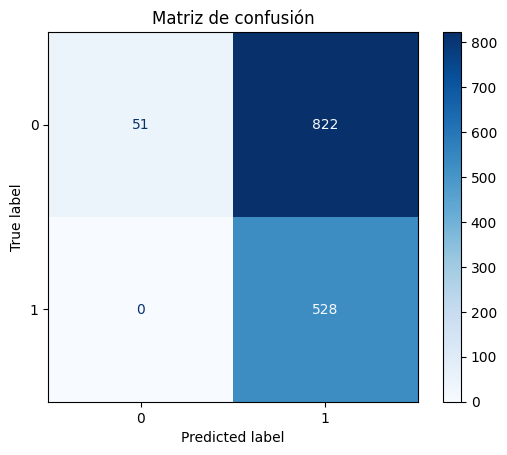

In [ ]:
# ----- Matriz de confusión -----
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión")
plt.show()


In [ ]:
import pandas as pd

# Unimos todos los IDs que aparecieron en algún resultado
all_ids = set(correct_ids_few) | set(incorrect_ids_few) & \
          set(correct_ids_contrast) | set(incorrect_ids_contrast) & \
          set(correct_ids_jer) | set(incorrect_ids_jer)

data = []
for idx in all_ids:
    data.append({
        "ID": idx,
        "FewShot": "Correcto" if idx in correct_ids_few else "Incorrecto",
        "Contrastive": "Correcto" if idx in correct_ids_contrast else "Incorrecto",
        "Jerarquico": "Correcto" if idx in correct_ids_jer else "Incorrecto",
    })

df_results = pd.DataFrame(data).sort_values("ID")
print(df_results)

# Agrupamos por combinaciones de resultados
grouped = df_results.groupby(["FewShot", "Contrastive", "Jerarquico"])

# Seleccionamos hasta 3 ejemplos por combinación
n = 3
sampled = grouped.apply(lambda g: g.sample(n=min(len(g), n), random_state=41)).reset_index(drop=True)

print(sampled)


        ID     FewShot Contrastive  Jerarquico
0        3    Correcto    Correcto    Correcto
2       12  Incorrecto    Correcto    Correcto
5       15    Correcto  Incorrecto  Incorrecto
7       18    Correcto    Correcto    Correcto
9       25    Correcto  Incorrecto    Correcto
...    ...         ...         ...         ...
1160  6988    Correcto    Correcto    Correcto
1162  6990    Correcto    Correcto  Incorrecto
1163  6996  Incorrecto    Correcto  Incorrecto
1164  6997    Correcto    Correcto  Incorrecto
1165  6998    Correcto    Correcto  Incorrecto

[1401 rows x 4 columns]
      ID     FewShot Contrastive  Jerarquico
0   4379    Correcto    Correcto    Correcto
1   2009    Correcto    Correcto    Correcto
2   1281    Correcto    Correcto    Correcto
3   2302    Correcto    Correcto  Incorrecto
4   5673    Correcto    Correcto  Incorrecto
5    562    Correcto    Correcto  Incorrecto
6   2175    Correcto  Incorrecto    Correcto
7   3059    Correcto  Incorrecto    Correcto
8   42

/tmp/ipython-input-686030958.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = grouped.apply(lambda g: g.sample(n=min(len(g), n), random_state=41)).reset_index(drop=True)


In [ ]:
df_results["kepid"] = kepi_ids[df_results["ID"]]
print(df_results)

        ID     FewShot Contrastive  Jerarquico     kepid
0        3    Correcto    Correcto    Correcto  10854555
2       12  Incorrecto    Correcto    Correcto  10984090
5       15    Correcto  Incorrecto  Incorrecto  10480982
7       18    Correcto    Correcto    Correcto  10583066
9       25    Correcto  Incorrecto    Correcto  11460018
...    ...         ...         ...         ...       ...
1160  6988    Correcto    Correcto    Correcto   9912977
1162  6990    Correcto    Correcto  Incorrecto   9959368
1163  6996  Incorrecto    Correcto  Incorrecto   4738095
1164  6997    Correcto    Correcto  Incorrecto  10079317
1165  6998    Correcto    Correcto  Incorrecto  10199817

[1401 rows x 5 columns]


In [ ]:
i=1
with pd.ExcelWriter("por_grupo.xlsx") as writer:
    for group_name, group_df in grouped:
        sheet_name = "H"+str(i)
        i+=1
        group_df.to_excel(writer, sheet_name=sheet_name, index=False)